# 👹 Adversarial training

Some computational substrates, for example mixed-signal neuromorphic processors or memristive cross-bar arrays, exhibit device variation from chip to chip and across the surface of a chip. This results in unknown parameter variation when a pre-trained network is deployed onto a chip.

This approach is described in more detail in *Büchel et al 2021* arXiv: https://arxiv.org/abs/2106.05009 .

## Network insensitivity to parameter noise via adversarial regularization

The high-level description of the algorithm is as follows:
In each training iteration, the network parameters are attacked by an adversary, whose goal it is to maximize the difference between the network output pre-attack and the network output post-attack. It does so by stepping up the gradient of a loss function $\mathcal{L}_{rob}(\cdot)$, which takes as arguments the outputs of the network using the attacked parameters and the original parameters. The network evaluation function is given as $f(X,\Theta)$, for input set $X$ and parameters $\Theta$.

This loss function is traditionally chosen as the KL-divergence between the softmaxed logits of both networks. In this tutorial, the MSE was chosen. Note that this function is separate and can be different from the task loss for whatever the network is being trained to do.

The adversary can take a fixed number of steps up the loss gradient, for each training iteration. The size of the steps it can take is also limited, such that the overall attack is described by a "mismatch level", which is roughly the percentage change in each parameter value that is permitted. e.g. a mismatch level of 10\% corresponds to a 10\% change of the values in each parameter from the nominal value.

This adversarial attack on the parameters is combined with noise injected into the parameters in each forward pass. Adding parameter noise also improves the robustness of the final network.

For each training iteration, the network optimises a hybrid loss which is a combination of the task loss $\mathcal{L}_{task}(\cdot)$ and the robustness loss $\mathcal{L}_{rob}(\cdot)$. By doing so the network learns to solve the task, but in such a way that the network is not badly affected by parameter noise.

The final loss that is being optimized is $\mathcal{L} = \mathcal{L}_{task}(f(X,\Theta)) + \beta_{rob} \cdot \mathcal{L}_{rob}(f(X,\Theta),f(X,\Theta^*))$, where $\Theta^*$ are the parameters found by the adversary from the nominal parameters $\Theta$, and $\beta_{rob}$ is a hyperparameter that weights the two components of the loss.

## The training modules required

```python
def adversarial_loss(
    parameters: Tree,
    net: JaxModule,
    inputs: np.ndarray,
    target: np.ndarray,
    task_loss: Callable[[np.ndarray, np.ndarray], float],
    mismatch_loss: Callable[[np.ndarray, np.ndarray], float],
    rng_key: JaxRNGKey,
    noisy_forward_std: float = 0.0,
    initial_std: float = 1e-3,
    mismatch_level: float = 0.025,
    beta_robustness: float = 0.25,
    attack_steps: int = 10,
) -> float:
```

This is a compilable, differentiable loss function based on `Jax`, that evaluates a network `net` on the parameters `parameters` ($\Theta$), over `input` with the desired output `target`. Internally it evaluates the hybrid loss $\mathcal{L}$ described above, by performing the adversarial attack.

You can supply arbitrary utility loss functions `task_loss()` ($\mathcal{L}_{task}$) and `mismatch_loss()` ($\mathcal{L}_{rob}$) to measure the network performance during training. These apply to the task performance (`task_loss()`) and provide the metric used by the adversarial attack (`mismatch_loss()`). These must be based on `Jax` to support automatic differentiation.

`noisy_forward_std` provides a way to add Gaussian noise to each parameter during the forward pass through the network. This encourages additional robustness to parameter variation. Keep this at `0.0` if you don't want to use forward noise.

`initial_std` is the amount of Gaussian noise added to the nominal parameters to initialise the parameters used by the adversary, as it starts its attack.

`mismatch_level` is a number > 0 which defines the maximum attack size the adversary is permitted to use. `1.0` means an attack size that is 100\% of the parameter scale.

`beta_robustness` is the weighting hyper-parameter $\beta_{rob}$, as described above.

`attack_steps` is the number of gradient-ascent steps taken by the adversary during its attack.

In [1]:
# - Useful imports
import warnings

warnings.filterwarnings("ignore")
from jax import config

config.FLAGS.jax_log_compiles = False
config.update("jax_disable_jit", False)

# - Import the adversarial training packages
from rockpool.training import jax_loss as l
from rockpool.training.adversarial_jax import adversarial_loss

In [2]:
# - Import the required Rockpool modules to build a network
from rockpool.nn.modules import LinearJax, InstantJax
from rockpool.nn.combinators import Sequential

# - Other useful imports
import jax
import jax.numpy as jnp
import jax.tree_util as tu
import jax.random as random
from jax.experimental.optimizers import adam, sgd
from jax.tree_util import Partial

from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count
import numpy as np

# - Seed the numpy RNG
np.random.seed(0)

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

## Network and training task
We will train a feed-forward network with one hidden layer, to perform a frozen-noise-to-curve regression task. The class below defines a random dataset to use in training.

In [3]:
# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(
        self,
        num_classes: int = 2,
        sample_length: int = 100,
        input_channels: int = 50,
        target_channels: int = 2,
    ):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length

        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.0

        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = (
            np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        )

        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(
            2 * np.pi * self._target_omega * time_base + self._target_phase
        )

    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes

    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return self._inputs[i], self._targets[i]


# - Define loss for standard network
def loss_mse(parameters, net, inputs, target):
    net = net.reset_state()
    net = net.set_attributes(parameters)
    output, _, _ = net(inputs)
    return l.mse(output, target)

In [4]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(
    num_classes=num_classes, input_channels=Nin, target_channels=Nout, sample_length=T
)

Nhidden = 8
N_train = 100
N_test = 50

data = {
    "train": [el for el in [sample for sample in ds] for _ in range(N_train)],
    "test": [el for el in [sample for sample in ds] for _ in range(N_test)],
}

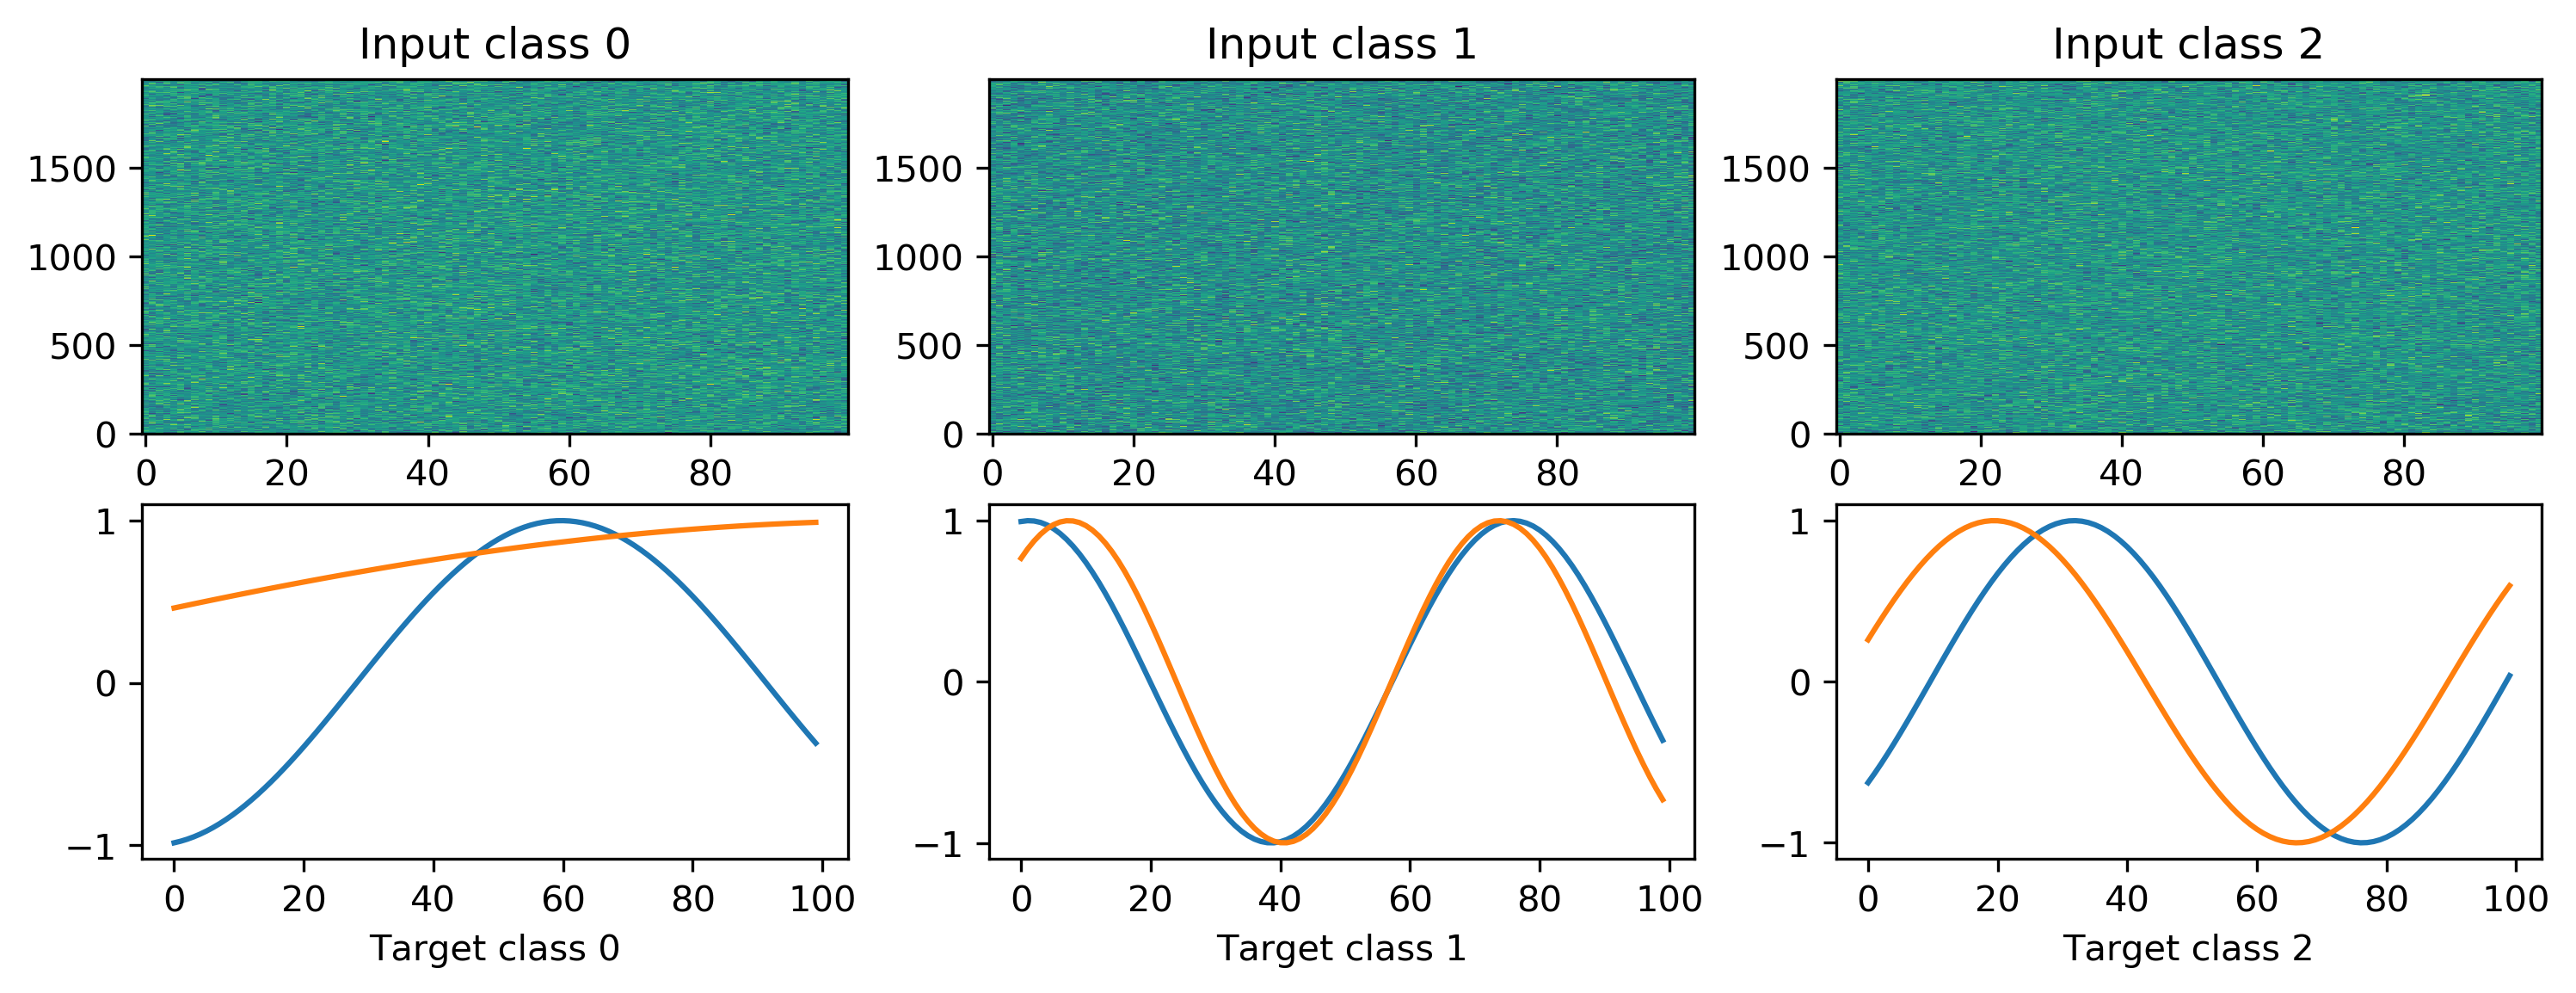

In [5]:
# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0].T, aspect="auto", origin="lower")
    plt.title(f"Input class {i}")

    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f"Target class {i}")

The function `train_net()` below defines a `Jax`-based training loop, parameterised by the loss functions used to evaluate the task and used by the adversary. This is a farily standard training loop that uses the Adam optimiser. It accepts several parameters for `adversarial_loss()` and passes them through.

In [6]:
# - Create a method that trains a network
def train_net(
    net,
    loss_vgf,
    data,
    num_epochs=1000,
    task_loss=None,
    mismatch_loss=None,
    noisy_forward_std=None,
    initial_std=None,
    mismatch_level=None,
    beta_robustness=None,
    attack_steps=None,
):

    # - Define initial seed
    rand_key = random.PRNGKey(0)

    # - Get the optimiser functions
    init_fun, update_fun, get_params = adam(1e-4)

    # - Initialise the optimiser with the initial parameters
    params0 = deepcopy(net.parameters())
    opt_state = init_fun(params0)

    # - Compile the optimiser update function
    update_fun = jax.jit(update_fun)

    # - Record the loss values over training iterations
    loss_t = []
    grad_t = []

    # - Loop over iterations
    i_trial = count()
    for _ in tqdm(range(num_epochs)):
        for sample in data:
            # - Get an input / target sample
            input, target = sample[0], sample[1]

            # - Get parameters for this iteration
            params = get_params(opt_state)

            # - Split the random key
            rand_key, sub_key = random.split(rand_key)

            # - Get the loss value and gradients for this iteration
            if mismatch_loss is None:
                # - Normal training
                loss_val, grads = loss_vgf(params, net, input, target)
            else:
                loss_val, grads = loss_vgf(
                    params,
                    net,
                    input,
                    target,
                    task_loss,
                    mismatch_loss,
                    sub_key,
                    noisy_forward_std,
                    initial_std,
                    mismatch_level,
                    beta_robustness,
                    attack_steps,
                )

            # - Update the optimiser
            opt_state = update_fun(next(i_trial), grads, opt_state)

            # - Keep track of the loss
            loss_t.append(loss_val)

    return net, loss_t, params

In [7]:
# - Define helper functions for evaluating the mismatch robustness of the network
def eval_loss(inputs, target, net):
    output, _, _ = net(inputs)
    return l.mse(output, target)


def split_and_sample_normal(key, shape):
    """
    Split an RNG key and generate random data of a given shape following a standard Gaussian distribution

    Args:
        key (RNGKey): Array of two ints. A Jax random key
        shape (tuple): The shape that the random normal data should have

    Returns:
        (RNGKey, np.ndarray): Tuple of `(key,data)`. `key` is the new key that can be used in subsequent computations and `data` is the Gaussian data
    """
    key, subkey = random.split(key)
    val = random.normal(subkey, shape=shape)
    return key, val

The function `get_average_loss_mismatch()` below evaluates the performance of the trained network under simulated mismatch. It performs `N` simulations of mismatch at level `mm_level`, based on the trained parameters `params`, then returns the mean and std. dev. of loss evaluated over `dataset`.

In [8]:
def get_average_loss_mismatch(
    dataset, mm_level, N, net, params, rand_key
) -> (float, float):
    params_flattened, tree_def_params = tu.tree_flatten(params)

    loss = []
    # - Perform N simulations of mismatch
    for _ in range(N):
        # - Simulate mismatch by adding noise to each parameter
        params_gaussian_flattened = []
        for p in params_flattened:
            rand_key, random_normal_var = split_and_sample_normal(rand_key, p.shape)
            params_gaussian_flattened.append(
                p + jnp.abs(p) * mm_level * random_normal_var
            )

        params_gaussian = tu.tree_unflatten(tree_def_params, params_gaussian_flattened)

        # - Apply the mismatched parameters to the network
        net = net.set_attributes(params_gaussian)

        # - Evaluate the test data and measure the loss
        loss_tmp = []
        for sample in dataset:
            # - Get an input / target sample
            inputs, target = sample[0], sample[1]
            net = net.reset_state()
            loss_tmp.append(eval_loss(inputs, target, net))
        loss.append(np.mean(loss_tmp))
    return np.mean(loss), np.std(loss)

Here we define the simple feed-forward network architecture.

In [9]:
# - Define number of epochs
num_epochs = 300

# - Create network
net = Sequential(
    LinearJax((Nin, Nhidden)),
    InstantJax(Nhidden, jnp.tanh),
    LinearJax((Nhidden, Nout)),
)

## Training the robust network
Now we will train a robust network using the adversarial attack described above, as well as a standard network using the task loss alone.

In [10]:
# - Train robust network
loss_vgf = jax.value_and_grad(adversarial_loss)
net_robust, loss_t_robust, params_robust = train_net(
    net=deepcopy(net),
    loss_vgf=loss_vgf,
    data=data["train"],
    num_epochs=num_epochs,
    task_loss=Partial(l.mse),
    mismatch_loss=Partial(l.mse),
    noisy_forward_std=0.1,
    initial_std=0.001,
    mismatch_level=0.025,
    beta_robustness=0.25,
    attack_steps=10,
)

In [11]:
# - Train a standard network
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))
net_standard, loss_t_standard, params_standard = train_net(
    net=deepcopy(net), loss_vgf=loss_vgf, data=data["train"], num_epochs=num_epochs
)

Having trained the networks, we will evaluate both robust and standard networks under simulated mismatch.

In [13]:
# - Evaluate the robustness of the networks
mismatch_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results = {
    "rob": {
        "mean": np.empty(len(mismatch_levels)),
        "std": np.empty(len(mismatch_levels)),
    },
    "standard": {
        "mean": np.empty(len(mismatch_levels)),
        "std": np.empty(len(mismatch_levels)),
    },
}
rand_key = random.PRNGKey(0)
N_rep = 20
for i, mm_level in enumerate(mismatch_levels):
    rob_mean, rob_std = get_average_loss_mismatch(
        dataset=data["test"],
        mm_level=mm_level,
        N=N_rep,
        net=net_robust,
        params=params_robust,
        rand_key=rand_key,
    )
    standard_mean, standard_std = get_average_loss_mismatch(
        dataset=data["test"],
        mm_level=mm_level,
        N=N_rep,
        net=net_standard,
        params=params_standard,
        rand_key=rand_key,
    )
    rand_key, _ = random.split(rand_key)
    results["rob"]["mean"][i] = rob_mean
    results["rob"]["std"][i] = rob_std
    results["standard"]["mean"][i] = standard_mean
    results["standard"]["std"][i] = standard_std

    print(f"ROBUST Mismatch level {mm_level} Loss {rob_mean}+-{rob_std}")
    print(f"STANDARD Mismatch level {mm_level} Loss {standard_mean}+-{standard_std} \n")

ROBUST Mismatch level 0.0 Loss 0.0022709257900714874+-0.0
STANDARD Mismatch level 0.0 Loss 7.176709004852455e-06+-0.0 

ROBUST Mismatch level 0.1 Loss 0.006857284810394049+-0.0029007974080741405
STANDARD Mismatch level 0.1 Loss 0.009090365841984749+-0.006808127276599407 

ROBUST Mismatch level 0.2 Loss 0.015149787068367004+-0.006593300495296717
STANDARD Mismatch level 0.2 Loss 0.03402901440858841+-0.015941761434078217 

ROBUST Mismatch level 0.3 Loss 0.03354230523109436+-0.019302567467093468
STANDARD Mismatch level 0.3 Loss 0.08264636248350143+-0.045148223638534546 

ROBUST Mismatch level 0.4 Loss 0.0664302408695221+-0.038513872772455215
STANDARD Mismatch level 0.4 Loss 0.15459516644477844+-0.07509110122919083 

ROBUST Mismatch level 0.5 Loss 0.10546185076236725+-0.053215377032756805
STANDARD Mismatch level 0.5 Loss 0.21760770678520203+-0.1716349869966507 

ROBUST Mismatch level 0.6 Loss 0.12933948636054993+-0.05928382650017738
STANDARD Mismatch level 0.6 Loss 0.291755348443985+-0.1422

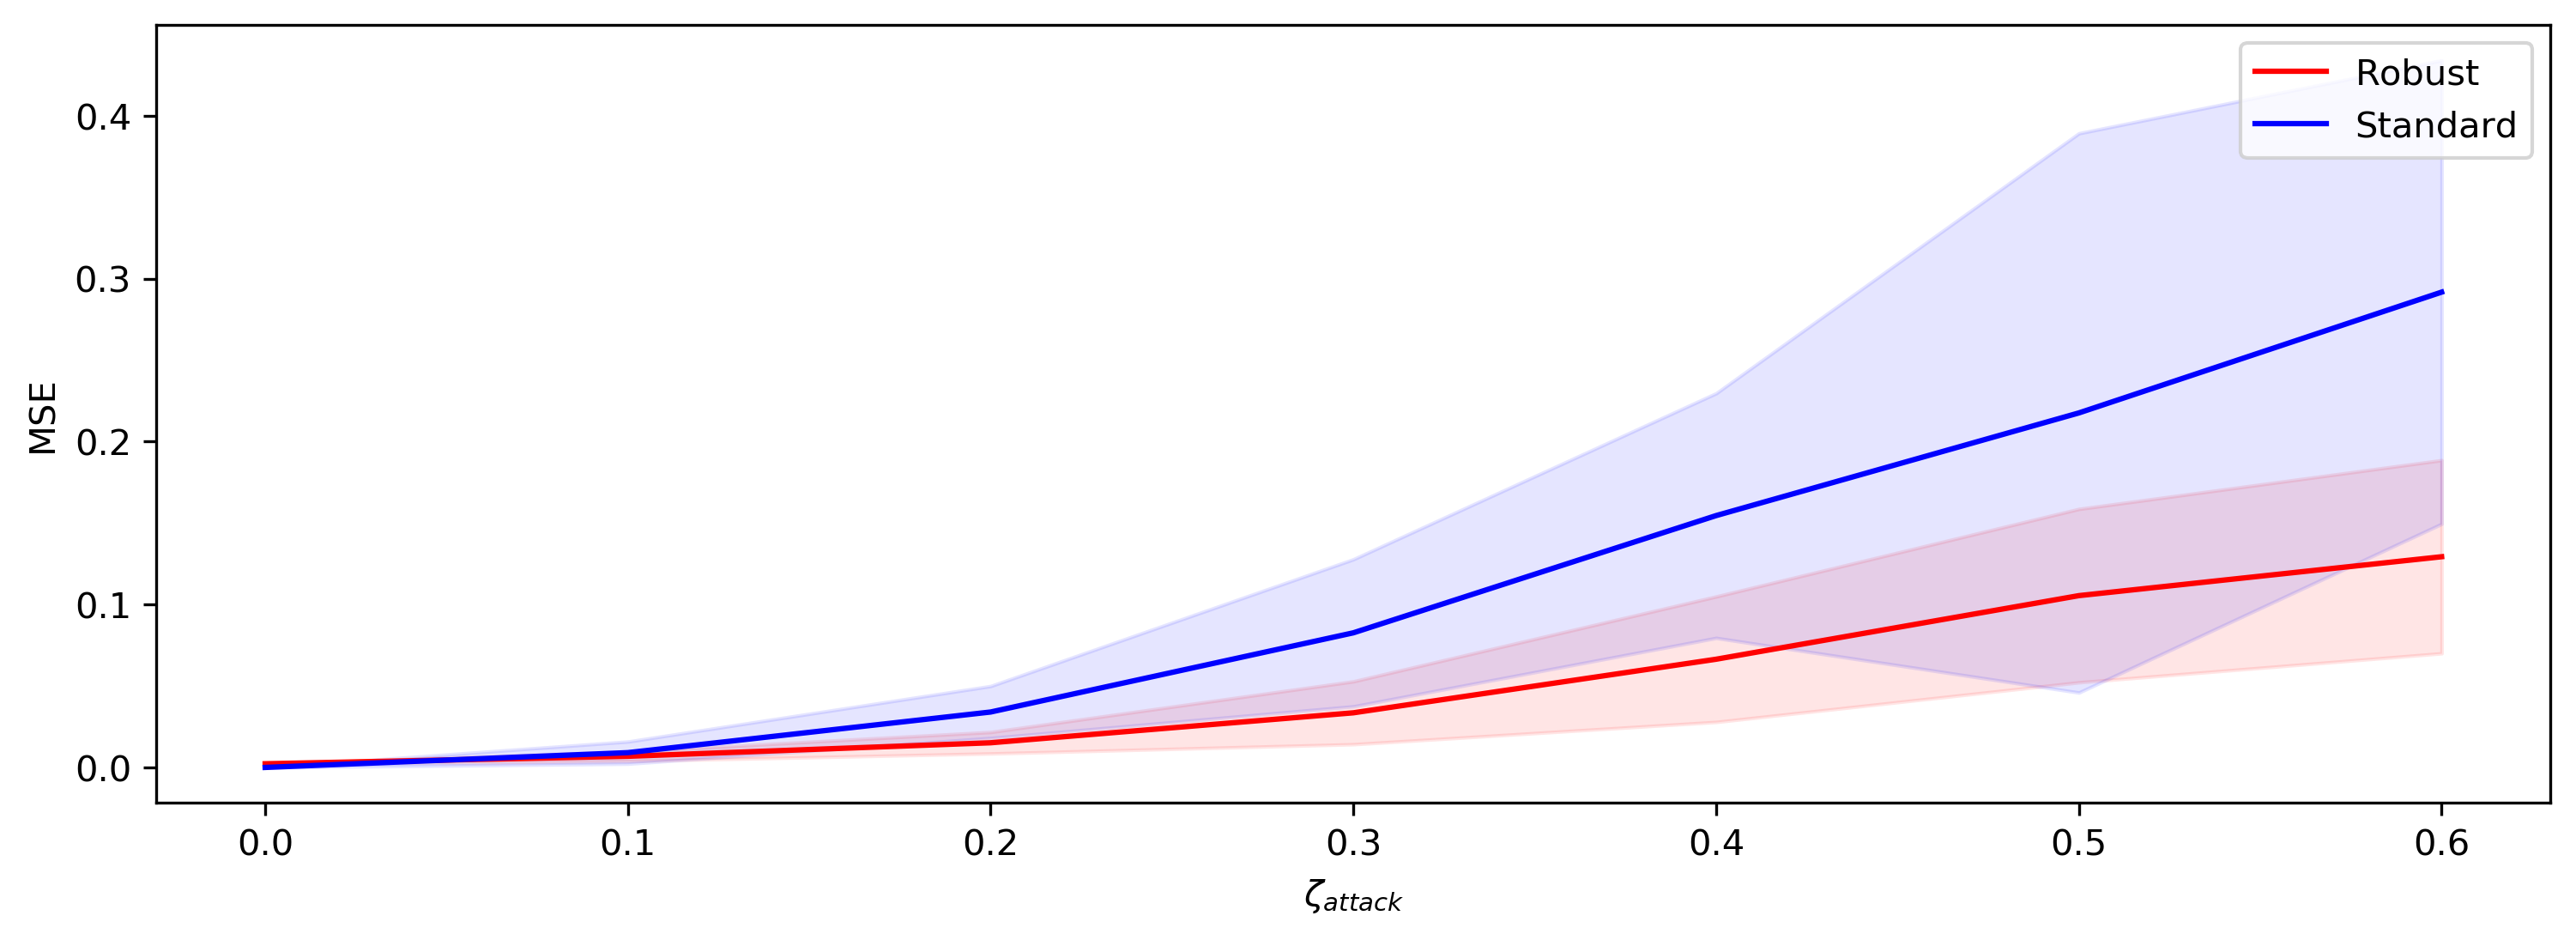

In [17]:
# - Plot the results
x = np.arange(0, len(mismatch_levels), 1)
plt.plot(x, results["rob"]["mean"], color="r", label="Robust")
plt.fill_between(
    x,
    results["rob"]["mean"] - results["rob"]["std"],
    results["rob"]["mean"] + results["rob"]["std"],
    alpha=0.1,
    color="r",
)

plt.plot(x, results["standard"]["mean"], color="b", label="Standard")
plt.fill_between(
    x,
    results["standard"]["mean"] - results["standard"]["std"],
    results["standard"]["mean"] + results["standard"]["std"],
    alpha=0.1,
    color="b",
)

plt.gca().set_xticks(x)
plt.gca().set_xticklabels([str(s) for s in mismatch_levels])
plt.gca().set_xlabel(r"$\zeta_{attack}$")
plt.ylabel("MSE")
plt.legend()
plt.show()

The robust network trained with the adversary performs almost as well as the network with standard training (i.e. low loss for `mismatch_level = 0.`. At the same time, the robust network is less sensitive to perturbations in the parameters (lower loss for `mismatch_level > 0`).